In [1]:
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install datasets
!pip install -q monai

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-1ayabncw
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-1ayabncw
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [64]:
# ==== General utilities ====
import os
import gc
import re
import json
import time
import shutil
import pickle
import random
from statistics import mean

# ==== Numerical and data handling ====
import numpy as np
import pandas as pd
from scipy import ndimage
from sklearn.model_selection import train_test_split

# ==== Image and visualization ====
import cv2
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# ==== Augmentation ====
from imgaug import augmenters as iaa
from imgaug import SegmentationMapsOnImage

# ==== PyTorch and training ====
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import _LRScheduler, ReduceLROnPlateau

# ==== Torchvision ====
import torchvision
import torchvision.models as models
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

# ==== Segmentation ====
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

# ==== Transformers ====
from transformers import SamModel, SamProcessor

# ==== MONAI ====
import monai

# ==== Evaluation and progress ====
from torchmetrics import ConfusionMatrix
from tqdm import tqdm

# ==== HuggingFace datasets ====
from datasets import Dataset


default_matplotlib_backend = matplotlib.get_backend()
print('imported')
print('default_matplotlib_backend: {}'.format(default_matplotlib_backend))

print(' numpy version', np.__version__)

imported
default_matplotlib_backend: module://matplotlib_inline.backend_inline
 numpy version 1.26.0


In [65]:
# Augmentation lists (reuse from CustomDataset)
augmentations_list = [
    iaa.Sharpen(alpha=(0, 0.5), lightness=(2.5, 3.0)),
    iaa.GammaContrast((0.4, 0.9)),
    iaa.AddToHueAndSaturation((-40, 20)),
    iaa.Multiply((1.1, 1.8))
]
zoomin_list = [
    iaa.Affine(scale=(1.2, 1.8)),
    iaa.Crop(percent=(0.01, 0.3))
]

def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
      x_min, x_max = np.min(x_indices), np.max(x_indices)
          y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
      x_min = max(0, x_min - np.random.randint(0, 20))
          x_max = min(W, x_max + np.random.randint(0, 20))
              y_min = max(0, y_min - np.random.randint(0, 20))
                  y_max = min(H, y_max + np.random.randint(0, 20))
                      bbox = [x_min, y_min, x_max, y_max]

                          return bbox

# SAMDataset with Augmentations
class SAMDataset(Dataset):
    def __init__(self, image_paths, mask_paths, processor, augmentations=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.processor = processor
        self.augmentations = augmentations

    def __len__(self):
        return len(self.image_paths)

    def transform(self, image, mask):
        resize = transforms.Resize(size=(512, 512))
        if self.augmentations:
            if random.random() > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)
            if random.random() > 0.5:
                image = TF.vflip(image)
                mask = TF.vflip(mask)
            if random.random() > 0.5:
                angle = random.randrange(45, 270)
                image = TF.rotate(image, angle)
                mask = TF.rotate(mask, angle)
            if random.random() > 0.6:
                image_np = np.array(image)
                bg_images_folder = ""  # Update with your BG folder path
                bg_images_list = [
                    f for f in os.listdir(bg_images_folder)
                    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
                ]

                if not bg_images_list:
                    raise ValueError("No valid background images found in the specified folder.")

                bg_image_choice = random.choice(bg_images_list)
                bg_image_path = os.path.join(bg_images_folder, bg_image_choice)

                # Read the background image
                background_image = cv2.imread(bg_image_path)

                if background_image is None:
                    raise ValueError(f"Failed to load background image: {bg_image_path}")

                # Resize the background image
                background_image = cv2.resize(background_image, (image_np.shape[1], image_np.shape[0]))

                # Combine with segmentation
                seg_image = np.where(mask == 0, 0, image_np)
                seg_image_with_background = np.where(seg_image != 0, 0, background_image)
                image = cv2.add(seg_image, seg_image_with_background)
                image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            if random.random() > 0.5:
                image_np = np.array(image)
                selected_augmentation = random.choice(augmentations_list)
                image_np = selected_augmentation.augment_image(image_np)
                image = Image.fromarray(image_np)
            if random.random() > 0.5:
                image_np = np.array(image)
                mask_np = np.array(mask)
                selected_augmentation = random.choice(zoomin_list)
                aug = iaa.Sequential([selected_augmentation])
                mask_segmaps = SegmentationMapsOnImage(mask_np, shape=mask_np.shape)
                zoom_image_np, masks_aug = aug(image=image_np, segmentation_maps=mask_segmaps)
                zoom_mask_np = masks_aug.get_arr()
                image = Image.fromarray(zoom_image_np)
                mask = Image.fromarray(zoom_mask_np)
    
        image = resize(image)
        mask = resize(mask)
        return image, mask

    def __getitem__(self, idx):
        try:
            # Load image and mask paths
            image_path = self.image_paths[idx]
            mask_path = self.mask_paths[idx]

            # Open image and mask
            image = Image.open(image_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")

            # Apply augmentations or transformations
            image, mask = self.transform(image, mask)
            image = np.array(image)
            # Get bounding box prompt from the mask
            ground_truth_mask = np.array(mask)
            prompt = get_bounding_box(ground_truth_mask)

            # Prepare inputs for the processor
            inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

            # Remove batch dimension added by the processor
            inputs = {k: v.squeeze(0) for k, v in inputs.items()}

            # Add ground truth segmentation mask to the inputs
            inputs["ground_truth_mask"] = ground_truth_mask
            inputs["image_path"] = image_path
            return inputs

        except Exception as e:
            # Log the error and skip the problematic data point
            print(f"Error loading data at index {idx}: {e}")
            return self.__getitem__((idx + 1) % len(self.image_paths))  # Move to the next item

In [66]:

# Load dataset file paths
def get_file_paths(data_dict, base_dir, base_dir_label):
    train_image_paths, val_image_paths, test_image_paths = [], [], []
    train_mask_paths, val_mask_paths, test_mask_paths = [], [], []
    for dataset, splits in data_dict.items():
        for rep, split in splits.items():
            for f in os.listdir(os.path.join(base_dir, dataset, rep)):
                image_path = os.path.join(base_dir, dataset, rep, f)
                mask_path = os.path.join(base_dir_label, dataset, rep, "masks", f.replace('.png', '_mask.png'))
                if split == 'train':
                    train_image_paths.append(image_path)
                    train_mask_paths.append(mask_path)
                elif split == 'valid':
                    val_image_paths.append(image_path)
                    val_mask_paths.append(mask_path)
                elif split == 'test':
                    test_image_paths.append(image_path)
                    test_mask_paths.append(mask_path)
    return train_image_paths, train_mask_paths, val_image_paths, val_mask_paths, test_image_paths, test_mask_paths

In [67]:
# Dataset-1 configuration
# Load data
train_valid_test_split_json_name_ds1 = ''
with open(train_valid_test_split_json_name_ds1, 'r') as f:
    data_dict_ds1 = json.load(f)

In [71]:
# Dataset-1 configuration
# Load data
train_valid_test_split_json_name_ds1 = ''
with open(train_valid_test_split_json_name_ds1, 'r') as f:
    data_dict_ds1 = json.load(f)

base_dir_ds1       = ""
base_dir_label_ds1 = ""

train_image_paths_ds1, train_mask_paths_ds1, val_image_paths_ds1, val_mask_paths_ds1, test_image_paths_ds1, test_mask_paths_ds1 = get_file_paths(
    data_dict_ds1, base_dir_ds1, base_dir_label_ds1
)

print('Dataset-1:')
print('Number of training images:', len(train_image_paths_ds1))
print('Number of validation images:', len(val_image_paths_ds1))
print('Number of test images:', len(test_image_paths_ds1))
print("DataLoaders ready for Dataset-1!")

# Dataset-2 configuration
# Load data
train_valid_test_split_json_name_ds2 = ''
with open(train_valid_test_split_json_name_ds2, 'r') as f:
    data_dict_ds2 = json.load(f)

base_dir_ds2       = ""
base_dir_label_ds2 = ""

train_image_paths_ds2, train_mask_paths_ds2, val_image_paths_ds2, val_mask_paths_ds2, test_image_paths_ds2, test_mask_paths_ds2 = get_file_paths(
    data_dict_ds2, base_dir_ds2, base_dir_label_ds2
)

print('Dataset-2:')
print('Number of training images:', len(train_image_paths_ds2))
print('Number of validation images:', len(val_image_paths_ds2))
print('Number of test images:',      len(test_image_paths_ds2))
print("DataLoaders ready for Dataset-2!")

# Dataset-3 configuration
# Load data
train_valid_test_split_json_name_ds3 = ''
with open(train_valid_test_split_json_name_ds3, 'r') as f:
    data_dict_ds3 = json.load(f)

base_dir_ds3       = ""
base_dir_label_ds3 = ""

train_image_paths_ds3, train_mask_paths_ds3, val_image_paths_ds3, val_mask_paths_ds3, test_image_paths_ds3, test_mask_paths_ds3 = get_file_paths(
    data_dict_ds3, base_dir_ds3, base_dir_label_ds3
)

print('Dataset-3:')
print('Number of training images:', len(train_image_paths_ds3))
print('Number of validation images:', len(val_image_paths_ds3))
print('Number of test images:',      len(test_image_paths_ds3))
print("DataLoaders ready for Dataset-3!")

Dataset-1:
Number of training images: 0
Number of validation images: 0
Number of test images: 8312
DataLoaders ready for Dataset-1!
Dataset-2:
Number of training images: 0
Number of validation images: 0
Number of test images: 18559
DataLoaders ready for Dataset-2!
Dataset-3:
Number of training images: 0
Number of validation images: 0
Number of test images: 4137
DataLoaders ready for Dataset-3!


In [72]:
 # Instantiate the processor (SAM model-specific)
from transformers import SamProcessor  # Replace with appropriate processor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")  # Update with your SAM model

In [74]:
def create_datasets(image_paths, mask_paths, processor, augmentations, dataset_number):
    """
    Create datasets with or without augmentation for a specific dataset number.
    
    Args:
        image_paths (list): List of image file paths.
        mask_paths (list): List of mask file paths.
        processor: The processor object for handling the dataset.
        augmentations (bool): Whether to apply augmentations.
        dataset_number (int): Dataset identifier (e.g., 1 or 2).

    Returns:
        tuple: Datasets (train, validation, test) with specified configurations.
    """
    train_dataset = SAMDataset(
        image_paths["train"], mask_paths["train"], processor, augmentations=augmentations
    )
    val_dataset = SAMDataset(
        image_paths["val"], mask_paths["val"], processor, augmentations=False
    )
    test_dataset = SAMDataset(
        image_paths["test"], mask_paths["test"], processor, augmentations=False
    )

    print(f"Dataset-{dataset_number} with {'augmentations' if augmentations else 'no augmentations'} created.")
    return train_dataset, val_dataset, test_dataset


# Example usage for Dataset-1
image_paths_ds1 = {
    "train": train_image_paths_ds1,
    "val": val_image_paths_ds1,
    "test": test_image_paths_ds1,
}
mask_paths_ds1 = {
    "train": train_mask_paths_ds1,
    "val": val_mask_paths_ds1,
    "test": test_mask_paths_ds1,
}

train_dataset_ds1, val_dataset_ds1, test_dataset_ds1 = create_datasets(
    image_paths_ds1, mask_paths_ds1, processor, augmentations=False, dataset_number=1
)

train_dataset_aug_ds1, val_dataset_aug_ds1, test_dataset_aug_ds1 = create_datasets(
    image_paths_ds1, mask_paths_ds1, processor, augmentations=True, dataset_number=1
)

# Example usage for Dataset-2
image_paths_ds2 = {
    "train": train_image_paths_ds2,
    "val": val_image_paths_ds2,
    "test": test_image_paths_ds2,
}
mask_paths_ds2 = {
    "train": train_mask_paths_ds2,
    "val": val_mask_paths_ds2,
    "test": test_mask_paths_ds2,
}

train_dataset_ds2, val_dataset_ds2, test_dataset_ds2 = create_datasets(
    image_paths_ds2, mask_paths_ds2, processor, augmentations=False, dataset_number=2
)

train_dataset_aug_ds2, val_dataset_aug_ds2, test_dataset_aug_ds2 = create_datasets(
    image_paths_ds2, mask_paths_ds2, processor, augmentations=True, dataset_number=2
)

# Example usage for Dataset-3
image_paths_ds3 = {
    "train": train_image_paths_ds3,
    "val": val_image_paths_ds3,
    "test": test_image_paths_ds3,
}
mask_paths_ds3 = {
    "train": train_mask_paths_ds3,
    "val": val_mask_paths_ds3,
    "test": test_mask_paths_ds3,
}

train_dataset_ds3, val_dataset_ds3, test_dataset_ds3 = create_datasets(
    image_paths_ds3, mask_paths_ds3, processor, augmentations=False, dataset_number=3
)

train_dataset_aug_ds3, val_dataset_aug_ds3, test_dataset_aug_ds3 = create_datasets(
    image_paths_ds3, mask_paths_ds3, processor, augmentations=True, dataset_number=3
)

Dataset-1 with no augmentations created.
Dataset-1 with augmentations created.
Dataset-2 with no augmentations created.
Dataset-2 with augmentations created.
Dataset-3 with no augmentations created.
Dataset-3 with augmentations created.


In [76]:
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size):
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"DataLoaders created with batch size {batch_size}.")
    return test_loader


# Example usage for Dataset-1 without augmentations
batch_size = 4
sam_test_loader_ds1 = create_dataloaders(
    train_dataset_ds1, val_dataset_ds1, test_dataset_ds1, batch_size
)


# Example usage for Dataset-2 without augmentations
sam_test_loader_ds2 = create_dataloaders(
    train_dataset_ds2, val_dataset_ds2, test_dataset_ds2, batch_size
)

# Example usage for Dataset-2 without augmentations
sam_test_loader_ds3 = create_dataloaders(
    train_dataset_ds3, val_dataset_ds3, test_dataset_ds3, batch_size
)

DataLoaders created with batch size 4.
DataLoaders created with batch size 4.
DataLoaders created with batch size 4.


In [77]:
def plot_sample_with_bbox(data_loader):
    """
    Plots a sample image with its bounding box (prompt for SAM) and mask from the DataLoader.
    Prints the shape, min, and max value of each.
    
    Args:
        data_loader (torch.utils.data.DataLoader): The DataLoader containing image and mask data.
    """
    # Get one batch of data
    batch = next(iter(data_loader))
    
    # Extract the first sample from the batch
    image_tensor = batch["pixel_values"]  # Assuming processor output has key "pixel_values"
    mask_tensor = batch["ground_truth_mask"]  # Assuming mask is included with this key
    print("paths", batch["image_path"])
    # Convert tensors to numpy arrays for visualization
    image = image_tensor[0].permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
    mask  = mask_tensor[0].numpy()  # Convert mask to numpy array
    
    # Get the bounding box (assumed to be present in the batch as 'input_boxes')
    bbox = batch["input_boxes"][0][0]  # Extract the first bounding box from the batch
    
    # Bounding box coordinates
    x_min, y_min, x_max, y_max = bbox
    
    # Print shape, min, and max of the image
    print(f"Image shape: {image.shape}, Min: {image.min()}, Max: {image.max()}")
    
    # Print shape, min, and max of the mask
    print(f"Mask shape: {mask.shape}, Min: {mask.min()}, Max: {mask.max()}")
    
    # Print bounding box coordinates
    print(f"Bounding box: [x_min: {x_min}, y_min: {y_min}, x_max: {x_max}, y_max: {y_max}]")
    
    # Plot the image with the bounding box
    plt.figure(figsize=(12, 6))
    
    # Plot the image
    plt.subplot(1, 2, 1)
    plt.imshow((image - image.min()) / (image.max() - image.min()))  # Normalize for display
    plt.title("Sample Image with Bounding Box")
    plt.axis("off")
    
    # Draw the bounding box
    ax = plt.gca()
    rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                     linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    
    # Plot the mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Sample Mask")
    plt.axis("off")
    
    plt.show()

paths ['/mnt/medaghub-ws/Rick/external_data/ext_dt_2/ext_dataset_2/T1211/pot_A1/182_64_2024-04-02_16-06-23_PS_Tray_1211_RGB2_pot_A1.png', '/mnt/medaghub-ws/Rick/external_data/ext_dt_2/ext_dataset_2/T1211/pot_A1/182_76_2024-04-06_16-02-58_PS_Tray_1211_RGB2_pot_A1.png', '/mnt/medaghub-ws/Rick/external_data/ext_dt_2/ext_dataset_2/T1211/pot_A1/182_73_2024-04-05_16-02-59_PS_Tray_1211_RGB2_pot_A1.png', '/mnt/medaghub-ws/Rick/external_data/ext_dt_2/ext_dataset_2/T1211/pot_A1/182_79_2024-04-07_16-02-58_PS_Tray_1211_RGB2_pot_A1.png']
Image shape: (1024, 1024, 3), Min: -2.1179039478302, Max: 0.5310677289962769
Mask shape: (512, 512), Min: 0, Max: 255
Bounding box: [x_min: 202.0, y_min: 318.0, x_max: 822.0, y_max: 788.0]


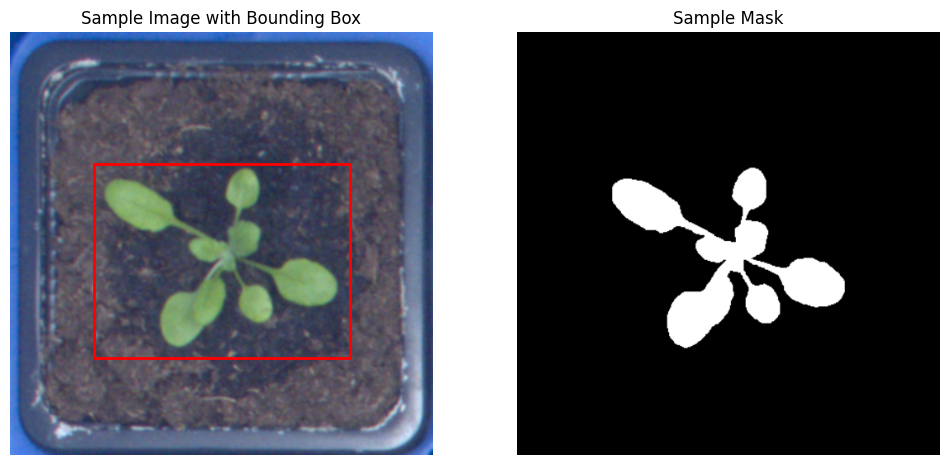

In [78]:
plot_sample_with_bbox(sam_test_loader_ds3)

In [79]:
import os
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from PIL import Image

def calculate_iou(predicted, ground_truth):
    """Calculate IoU based on black pixels from the difference between masks."""
    difference_mask = np.abs(predicted - ground_truth)
    black_pixels = np.sum(difference_mask == 0)
    total_pixels = difference_mask.size
    return black_pixels / total_pixels if total_pixels != 0 else 0

def save_predicted_masks(model, test_loader, dataset_name, device="cuda"):
    output_folder = f"output_ds/{dataset_name}"
    model.eval()
    model.to(device)

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Saving Masks", unit="batch"):
            images = batch["pixel_values"].to(device)
            input_boxes = batch["input_boxes"].to(device)
            image_paths = batch["image_path"]
            outputs = model(
                pixel_values=images,
                input_boxes=input_boxes,
                multimask_output=False
            )
            predicted_probs = outputs.pred_masks

            if predicted_probs.dim() == 5 and predicted_probs.shape[2] == 1:
                predicted_probs = predicted_probs.squeeze(2)

            for idx, image_path in enumerate(image_paths):
                original_image = Image.open(image_path).convert("RGB")
                original_image_np = np.array(original_image)

                pred_mask = predicted_probs[idx].cpu().numpy().squeeze()
                pred_mask_resized = F.interpolate(
                    torch.tensor(pred_mask).unsqueeze(0).unsqueeze(0), 
                    size=(640, 640), mode="bilinear", align_corners=False
                ).squeeze().numpy()

                pred_mask_binary = (pred_mask_resized > 0.5).astype(np.uint8) * 255

                # Resize original image to match binary mask size
                resized_original_image = Image.fromarray(original_image_np).resize((640, 640))
                resized_original_image_np = np.array(resized_original_image)

                plant_name = os.path.basename(os.path.dirname(os.path.dirname(image_path)))
                replicate_name = os.path.basename(os.path.dirname(image_path))
                file_name = os.path.basename(image_path)

                plant_folder = os.path.join(output_folder, plant_name)
                replicate_folder = os.path.join(plant_folder, replicate_name)
                masks_folder = os.path.join(replicate_folder, "masks")
                segmented_images_folder = os.path.join(replicate_folder, "segmented_images")

                os.makedirs(masks_folder, exist_ok=True)
                os.makedirs(segmented_images_folder, exist_ok=True)

                # Save binary mask
                binary_mask_path = os.path.join(masks_folder, file_name)
                Image.fromarray(pred_mask_binary).save(binary_mask_path)

                # Apply mask to resized original image
                segmented_image = resized_original_image_np.copy()
                segmented_image[pred_mask_binary == 0] = 0

                segmented_image_path = os.path.join(segmented_images_folder, file_name)
                Image.fromarray(segmented_image).save(segmented_image_path)

    print(f"Masks and segmented images saved to {output_folder}")

In [80]:
def configure_loaders_and_save_path(
    train_loader, val_loader, test_loader, 
    train_loader_aug, val_loader_aug, test_loader_aug,
    use_augmentation, save_path, dataset_number
):
    """
    Configure existing DataLoaders and update the save path based on augmentation usage and dataset number.
    """
    if use_augmentation:
        selected_train_loader = train_loader_aug
        selected_val_loader = val_loader_aug
        selected_test_loader = test_loader_aug
        save_path = f"{save_path}_dataset{dataset_number}_aug"
    else:
        selected_train_loader = train_loader
        selected_val_loader = val_loader
        selected_test_loader = test_loader
        save_path = f"{save_path}_dataset{dataset_number}"

    print(f"Using {'augmentation' if use_augmentation else 'standard'} loaders for Dataset-{dataset_number}.")
    print(f"Model will be saved at: {save_path}")
    
    return selected_train_loader, selected_val_loader, selected_test_loader, save_path

In [81]:
USE_2_GPUS = False  

model = SamModel.from_pretrained("facebook/sam-vit-base")

# Freeze parts of the model if needed
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

# Multi-GPU or single-GPU setup
if USE_2_GPUS and torch.cuda.device_count() > 1:
    print("Using DataParallel for multi-GPU training.")
    model = nn.DataParallel(model)

# Move model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [82]:
path = ""
model.load_state_dict(torch.load(path, map_location="cuda"))

/tmp/ipykernel_3245283/1309497609.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location="cuda"))


<All keys matched successfully>

In [62]:
save_predicted_masks(
    model=model,
    test_loader=sam_test_loader_ds1,
    dataset_name="ext_dataset_1",
    device="cuda"
)

Saving Masks: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2078/2078 [25:55<00:00,  1.34batch/s]

Masks and segmented images saved to output_ds


In [84]:
save_predicted_masks(
    model=model,
    test_loader=sam_test_loader_ds2,
    dataset_name="accessions_dataset2",
    device="cuda"
)

Saving Masks: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4640/4640 [57:02<00:00,  1.36batch/s]

Masks and segmented images saved to output_ds/accessions_dataset2


In [1]:
save_predicted_masks(
    model=model,
    test_loader=sam_test_loader_ds3,
    dataset_name="ext_dataset_2",
    device="cuda"
)